In [1]:
import os
import numpy as np
import pandas as pd
from itertools import combinations, product
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils import resample

from joblib import Parallel, delayed

import seaborn as sns
import matplotlib.pyplot as plt

from subfunctions import utils

In [2]:
# Parameters

# Data are publicly available https://doi.org/10.5061/dryad.gf1vhhn1j
DIR_DATA = '../Data'

## experiment 1: uninstructed inner speeech strategy
FP_UNINSTRUCTED_SINGLE   = os.path.join(DIR_DATA, 'seqRecallUninstructedSingleArrow', 't12.2023.05.16_binnedTX_spikePow_20ms_joystickSingle.mat')
FP_UNINSTRUCTED_ARROWSEQ = os.path.join(DIR_DATA, 'seqRecallUninstructed3ElementArrow', 't12.2023.05.16_binnedTX_spikePow_20ms_joystickSeq.mat')
FP_UNINSTRUCTED_LINESEQ  = os.path.join(DIR_DATA, 'seqRecallUninstructed3ElementLines', 't12.2023.09.19_binnedTX_spikePow_20ms_lineSequenes.mat')
# 2 second window of neural data immediately before go cue
ANALYSIS_WIN_DELAY = [-2000//20, 0]

## Experiment 2: instructed mental strategy switch
# FP_MENTAL_STRATEGY_SWAP = os.path.join(DIR_DATA,'t12.2023.10.12', 't12.2023.10.12_binnedTX_spikePow_20ms.mat')
FP_INSTRUCTED_VERBALMEM = os.path.join(DIR_DATA, 'seqRecallVerbalMemory', 't12.2023.10.12_binnedTX_spikePow_20ms_verbalMemory.mat')
FP_INSTRUCTED_VISUALMEM = os.path.join(DIR_DATA, 'seqRecallVisualMemory', 't12.2023.10.12_binnedTX_spikePow_20ms_visualMemory.mat')

# flag to include do nothing condition for plotting
INCLUDE_DONOTHING = False

## Experiment 3: inner speech and speech similarity.
FP_T12_ARROW = os.path.join(DIR_DATA,'seqRecallVerbalMemory', 't12.2023.09.28_binnedTX_spikePow_20ms_arrow.mat')
FP_T12_SPEAK = os.path.join(DIR_DATA,'seqRecallSpeech','t12.2023.09.28_binnedTX_spikePow_20ms_speak.mat')

# names of sequence position columns in assembled dataframe
SEQ_POS_COLS = np.array(['First', 'Second', 'Third'])



ALPHA_HYPOTHESIS_TESTING = 0.05
clf = LinearDiscriminantAnalysis()
 
# Task design images to approximate final figure
IMAGE_DIR = '../subpanels' 
FP_EXPERIMENT1_TASK = os.path.join(IMAGE_DIR,'experiment1TaskDesign.png')
FP_MENTAL_STRATEGY_SWAP_TASK = os.path.join(IMAGE_DIR,'experiment2TaskDesign.png')
FP_GENERALIZE_TASK = os.path.join(IMAGE_DIR,'experiment3TaskDesign.png')

# check all files and directories exist
for fp in [FP_UNINSTRUCTED_SINGLE, FP_UNINSTRUCTED_ARROWSEQ, FP_UNINSTRUCTED_LINESEQ,
            FP_INSTRUCTED_VERBALMEM, FP_INSTRUCTED_VISUALMEM, FP_T12_ARROW, FP_T12_SPEAK]:
    if not os.path.exists(fp):
        raise FileNotFoundError(f"File not found: {fp}, did you download data from https://doi.org/10.5061/dryad.gf1vhhn1j?")

for fp in [FP_EXPERIMENT1_TASK, FP_MENTAL_STRATEGY_SWAP_TASK, FP_GENERALIZE_TASK]:
    if not os.path.exists(fp):
        raise FileNotFoundError(f"Image file not found: {fp}")

# Experiment 1: Uninstructed use of inner speech
We hypothesized that we could naturally elicit the use of inner speech by modulating the difficulty and stimuli for a simple hand motor task. T12 was instructed to produce sequences of movents that were visually cued either using arrows or pictures of line segments during a delay-go paradigm. During the go period the stimuli were removed and T12 had to recal the cued movement directions and reproduce them from memory. We hypothesized that when cued to move in a single direction, simple motor preparation without the use of inner speech would be the natural mental strategy to produce the intended  movement.

The next task asked T12 to produce sequences of movements which could be accomplished by using inner speech to remember the directions fo the movements. 

In the final task T12 was cued with an image that she was asked to reproduce. This task could be done eintirely with a visual mental strategy rather than a language based mental strategy while the output was still a sequential hand motor task.

## Load T12 data as dataframes

In [3]:
uninstructedSingle, channel_map_t12 = utils.assembleGoAlignedWin(FP_UNINSTRUCTED_SINGLE, utils.cueConditionsSingle, 
                                       ANALYSIS_WIN_DELAY, featureNames = ['binnedTX'], featureColNames=['tx'])

uninstructedInnerSeechSeq, channel_map_t12   = utils.assembleGoAlignedWin(FP_UNINSTRUCTED_ARROWSEQ, utils.cueConditionsSeq, 
                                                        ANALYSIS_WIN_DELAY, featureNames = ['binnedTX'], featureColNames=['tx'])
uninstructedNoInnerSeechSeq, channel_map_t12 = utils.assembleGoAlignedWin(FP_UNINSTRUCTED_LINESEQ, utils.cueConditionsSeq, 
                                                        ANALYSIS_WIN_DELAY, featureNames = ['binnedTX'], featureColNames=['tx'])
uninstructedNoInnerSeechSeq['sequenceLength'] = uninstructedNoInnerSeechSeq.cue.apply(lambda x: len(x.split(' ')))
uninstructedNoInnerSeechSeq.loc[uninstructedNoInnerSeechSeq.cue=='Do Nothing', 'sequenceLength'] = 0

# remove do nothing trials since not used in analysis
uninstructedInnerSeechSeq = uninstructedInnerSeechSeq[uninstructedInnerSeechSeq.cue!='Do Nothing']
uninstructedSingle = uninstructedSingle[uninstructedSingle.cue!='Do Nothing']

# only use line sequences of length 3
uninstructedNoInnerSeechSeq = uninstructedNoInnerSeechSeq[uninstructedNoInnerSeechSeq.sequenceLength==3]

In [4]:

def decodePerPosition(taskDf, channel_map, x_val_folds=5):
    params = []
    for region, channels in channel_map.items():
 
        for position in SEQ_POS_COLS:
            other_positions = SEQ_POS_COLS[SEQ_POS_COLS!=position]
            other_position_values = taskDf[other_positions].sum(axis=1).unique()

            # pairwise comparison so the only difference between sequences should be in the one position.
            for other_pos_value0, other_pos_value1 in other_position_values:
                # only do two-way decoding so that chance is at 50%
                seqIdx = np.logical_and(taskDf[other_positions[0]]==other_pos_value0, 
                                        taskDf[other_positions[1]]==other_pos_value1)
                moveDirections = taskDf.loc[seqIdx, position].unique()
                for class0, class1 in combinations(moveDirections,r=2):
                    params.append((region, channels, position, class0, class1, other_positions, other_pos_value0, other_pos_value1))

    decodingPerformance = []
    for region, channels, position, class0, class1, other_positions, other_pos_value0, other_pos_value1 in tqdm(params):
        positionDecodePerformance = decodeSingelMoveDir(taskDf, channels, position, class0, class1, 
                                            other_positions, other_pos_value0, other_pos_value1, 
                                            region, x_val_folds=x_val_folds)
        decodingPerformance.append(positionDecodePerformance)
    return pd.concat(decodingPerformance)

def decodeSingelMoveDir(taskDf, channels, position, class0, class1,
                        other_positions, other_pos_value0, other_pos_value1, region, 
                        x_val_folds=5, estimator=clf, njobs=-1):


    # this is meant to be easily parallelized for different inputs
    # pariwise analysis so inary decoding at a specific position for a p[ir of cues that differ only in that position]
    thisItrIdx = np.logical_and.reduce([((taskDf[position]==class0) | (taskDf[position]==class1)),
                                        taskDf[other_positions[0]]==other_pos_value0,
                                        taskDf[other_positions[1]]==other_pos_value1])
                                        
    fitX = taskDf.loc[thisItrIdx,channels].values
    fitY = taskDf.loc[thisItrIdx,position].values

    predictions = cross_val_predict(estimator = estimator,
                        X = fitX,
                        y = fitY,
                        cv=x_val_folds,
                        n_jobs=njobs)
    hits_misses = predictions == fitY

    otherPosInterpretable = ' '.join([other_pos_value0, other_pos_value1])

    n_samples = len(fitY)
    # return cross-validated hits/misses to resample over them later
    performance = pd.DataFrame({'hits/misses':hits_misses,
                                    'position':[position]*n_samples,
                                    'class0':[class0]*n_samples,
                                    'class1':[class1]*n_samples,
                                    'other_position_seq':[otherPosInterpretable]*n_samples,
                                    'region':[region]* n_samples})
    return performance

In [ ]:
def resampled_each_decoder_hits_misses(data,replace=True):
    # resample hits/misses for each decoder
    resampled_accuracy = resample(data['hits/misses'],replace=replace)
    return resampled_accuracy

def resample_decoder_accuracy_by_position(experimentDecodingResults):
    # resample each decoder individually
    experimentDecodingResultsResampled = experimentDecodingResults.groupby(['position','Task name','class0','class1','other_position_seq','region'],dropna=False).apply(resampled_each_decoder_hits_misses).reset_index().drop('level_6',axis=1)
    
    # average over each position to get a per-position estimate of decodability for each task and region. 
    # this is one estimate of the distribution,to be repeateed many times to get a bootstrapped CI for per-position decoding accuracy
    positionDecodingAccuracyEstimate = experimentDecodingResultsResampled.drop(['class0','class1','other_position_seq'],axis=1).groupby(['position','Task name','region']).mean().reset_index()
    positionDecodingAccuracyEstimate['Accuracy'] = positionDecodingAccuracyEstimate['hits/misses']
    positionDecodingAccuracyEstimate.drop('hits/misses',axis=1,inplace=True)
    return positionDecodingAccuracyEstimate

def bootstrap_accuracy_CI_by_position(experimentDecodingResults, n_resamples=10000, n_jobs=-1, seed=42):
    """boostrapped estimate of CI for decoding accuracy by position. Each decoder's hits/misses are resampled and averaged to get one draw from the distribution of
    decoding accuracy for each position, task, and region. This is repeated many times to get a distribution of decoding accuracy for each position, task, and region.
    The 95% CI is then taken from this distribution as the 0.025 and 0.975 quantiles.

    Parameters
    ----------
    experimentDecodingResults : pandas.DataFrame
        prediction hits and misses for each decoder. each decoder is defined by the research task, brain region used to fit decoder,
        sequence position in which the two cues differ, and the two cues that differ in that position, and the fixed directions in the other sequence positions.

    n_resamples : int, optional
        number of times to resample for boostrapped estimate of CI, by default 1000
    n_jobs : int, optional
        number of cores to use for parallelized resampling, by default -1

    Returns
    -------
    pandas.DataFrame
        0.25, 0.5, and 0.975 quantiles of decoding accuracy for each position, task, and region
    """
    # set seed for consistency
    np.random.seed(seed)
    # for performance, parallelize resampling
    resampled_accuracy_by_position = pd.concat(Parallel(n_jobs=n_jobs)(delayed(resample_decoder_accuracy_by_position)(experimentDecodingResults) for _ in range(n_resamples)))
    
    # for debugging run in serial
    # resampled_accuracy_by_position = []
    # for _ in tqdm(range(n_resamples)):
    #     resampled_accuracy_by_position.append(resample_decoder_accuracy_by_position(experimentDecodingResults))
    # resampled_accuracy_by_position = pd.concat(resampled_accuracy_by_position)

    bootstrapped_CI_accuracy_by_position = resampled_accuracy_by_position.groupby(['position','Task name','region']).quantile([.025, 0.5, 0.975]).reset_index()
    bootstrapped_CI_accuracy_by_position['quantile'] = bootstrapped_CI_accuracy_by_position['level_3']
    bootstrapped_CI_accuracy_by_position.drop('level_3',axis=1,inplace=True)
    return bootstrapped_CI_accuracy_by_position

def plot_box_compare(experimentDecodingResults,  ax=None, sns_kws={}, region = 'i6v',
                     titlefontsize=11,ylabelsize=11, ticklabelsize=9, legendsize=9, legendtitlesize=11,legend_loc=[1.3,1],
                     taskColors = None, experimentBootstrappedCI=None, x_pos_asterisk_offset=0.5, x_pos_asterisk_scale = 0.5, chance_performance = 0.5):
    if ax is None:
        fig = plt.figure(figsize=[8,3])        
        ax = fig.add_subplot(111)
        
    # get accuracy for plotting:
    experimentDecodingAccuracy = experimentDecodingResults.groupby(['position','class0','class1','other_position_seq','region','Task name'], dropna=False).mean().reset_index()
    experimentDecodingAccuracy['Accuracy'] = experimentDecodingAccuracy['hits/misses']

    sns.boxplot(data=experimentDecodingAccuracy[experimentDecodingAccuracy.region==region], x='position',y='Accuracy', hue='Task name',
                ax=ax, fliersize=3,**sns_kws)
    # sns.stripplot(data=experimentDecodingAccuracy[experimentDecodingAccuracy.region==region], x='position',y='Accuracy', hue='Task name',
    #             ax=ax, dodge=True, edgecolor='gray', **sns_kws)
    
    if type(experimentBootstrappedCI) is pd.DataFrame:
        # Adding significance asterisks
        for position_idx, position in enumerate(experimentDecodingAccuracy['position'].unique()):
            for task_idx, task_name in enumerate(experimentDecodingAccuracy['Task name'].unique()):
                # Get the CI data for this region, position, and task
                ci_data = experimentBootstrappedCI[
                    (experimentBootstrappedCI['position'] == position) & 
                    (experimentBootstrappedCI['region'] == region) & 
                    (experimentBootstrappedCI['Task name'] == task_name)
                ]
                
                if not ci_data.empty:
                    lower_bound = ci_data[ci_data['quantile'] == 0.025]['Accuracy'].values[0]
                    
                    # If the confidence interval does not overlap with chance, add an asterisk
                    if lower_bound > chance_performance:
                        x_pos = position_idx + (task_idx -x_pos_asterisk_offset)*x_pos_asterisk_scale
                        y_pos = experimentDecodingAccuracy[
                            (experimentDecodingAccuracy['position'] == position) & 
                            (experimentDecodingAccuracy['region'] == region)
                        ]['Accuracy'].max()
                        
                        ax.text(x_pos, y_pos + 0.05, '*', ha='center', va='bottom', color='black', fontsize=14)
    
    ax.set_title(region,y=1.1)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylabel(ax.get_ylabel(), fontsize=ylabelsize)    
    sns.despine(trim=True, ax=ax, left=False)
    ax.set_xlabel('Sequence Position')
    ax.set_ylim(0, 1)
    xmin, xmax = ax.get_xlim()
    ax.hlines(0.5, xmin, xmax, color='k', ls=':', alpha=0.5)

    # Set font sizes
    ax.tick_params(axis='both', labelsize=ticklabelsize)
    

    legend = ax.legend(bbox_to_anchor=legend_loc,frameon=False)

    for text in legend.texts:
        text.set_fontsize(legendsize)
    legend.set_title('Task', prop={'size': legendtitlesize})

    return ax

In [6]:
# single element arrows tak only has one position so I wrote this cell to just handle this case
taskDf = uninstructedSingle.dropna()
position='First'
estimator = LinearDiscriminantAnalysis()
scoring='Accuracy'
x_val_folds=5
njobs=-1
n_permutations = 1000

decodingPerformance = []
for region, channels in channel_map_t12.items():
    moveDirections = taskDf[position].unique()
    for class0, class1 in combinations(moveDirections,r=2):
        classIdx = (taskDf[position]==class0) | (taskDf[position]==class1)

        fitX = taskDf.loc[classIdx,channels].values
        fitY = taskDf.loc[classIdx,position].values

        # do regular cross validation if test and train tasks are the same
        performance = cross_val_predict(estimator = estimator,
                            X = fitX,
                            y = fitY,
                            cv=x_val_folds,
                            n_jobs=njobs)
        hits_misses = performance==fitY

        # return mean over xval and metadata about this run
        performanceSeries = pd.DataFrame({'hits/misses':hits_misses})
        performanceSeries['position'] = position
        performanceSeries['class0'] = class0
        performanceSeries['class1'] = class1
        performanceSeries['region'] = region
        performanceSeries['other_position_seq'] = float('nan')

 
        decodingPerformance.append(performanceSeries)

decodingPerformanceSingle = pd.concat(decodingPerformance)

In [7]:
decodingPerformanceSingle['Task name'] = 'single-element arrow'
decodingPerformanceHardLanguage = decodePerPosition(uninstructedInnerSeechSeq, channel_map_t12)
decodingPerformanceHardLanguage['Task name'] = '3-element arrows'
decodingPerformanceHardVisual = decodePerPosition(uninstructedNoInnerSeechSeq, channel_map_t12)
decodingPerformanceHardVisual['Task name'] = '3-element lines'

experiment1DecodingResults = pd.concat([decodingPerformanceHardLanguage, decodingPerformanceHardVisual, decodingPerformanceSingle])
experiment1BootstrappedCI = bootstrap_accuracy_CI_by_position(experiment1DecodingResults)

100%|██████████| 96/96 [00:01<00:00, 71.14it/s]


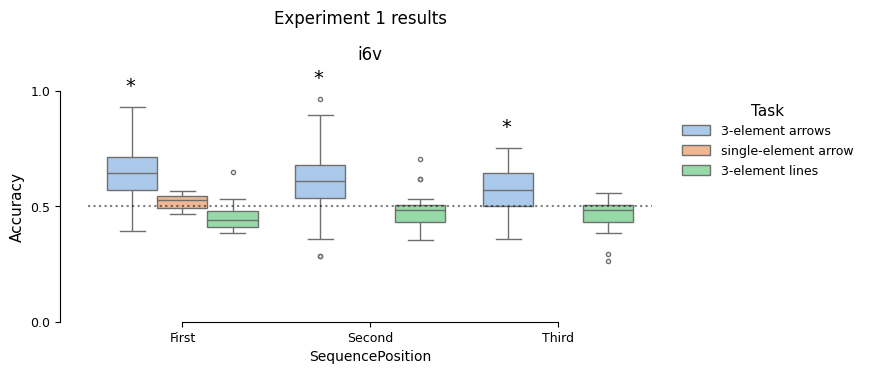

significant decoding accuracies:
   position         Task name region  Accuracy  quantile
0     First  3-element arrows    i6v  0.633557     0.025
18   Second  3-element arrows    i6v  0.597098     0.025
30    Third  3-element arrows    i6v  0.549851     0.025


In [8]:
ax = plot_box_compare(experiment1DecodingResults, experimentBootstrappedCI=experiment1BootstrappedCI, sns_kws={'palette':'pastel'},x_pos_asterisk_offset=1.1, x_pos_asterisk_scale=0.25)
plt.suptitle('Experiment 1 results',y=1.15)
plt.show(ax)

experiment1BoostrappedCI_i6v = experiment1BootstrappedCI[experiment1BootstrappedCI.region=='i6v']
print("significant decoding accuracies:")
print(experiment1BoostrappedCI_i6v[(experiment1BoostrappedCI_i6v['quantile']==0.025) & (experiment1BoostrappedCI_i6v.Accuracy>0.5)])

# Experiment 2: Instructed mental strategy switch
Next, we wanted to test whether T12 could volitionally switch between using inner speech or not using inner speech to accomplish the same motor task. 

In [12]:
verbalMemory, channel_map_t12 = utils.assembleGoAlignedWin(FP_INSTRUCTED_VERBALMEM, utils.cueConditionsSeq,
                                                     ANALYSIS_WIN_DELAY)

visualMemory, channel_map_t12 = utils.assembleGoAlignedWin(FP_INSTRUCTED_VISUALMEM, utils.cueConditionsSeq,
                                                     ANALYSIS_WIN_DELAY)
# remove do nothing trials since not used in analysis
verbalMemory = verbalMemory[verbalMemory.cue!='DO_NOTHING']
visualMemory = visualMemory[visualMemory.cue!='DO_NOTHING']

In [13]:
decodingInstructedInnerSpeech = decodePerPosition(verbalMemory, channel_map_t12)
decodingInstructedInnerSpeech['Task name'] = 'verbal memory'
decodingInstructedNoInnerSpeech = decodePerPosition(visualMemory, channel_map_t12)
decodingInstructedNoInnerSpeech['Task name'] = 'visual memory'

experiment2DecodingResults = pd.concat([decodingInstructedInnerSpeech, decodingInstructedNoInnerSpeech])

100%|██████████| 24/24 [00:00<00:00, 72.50it/s]


Text(0.5, 1.15, 'Experiment 2 results')

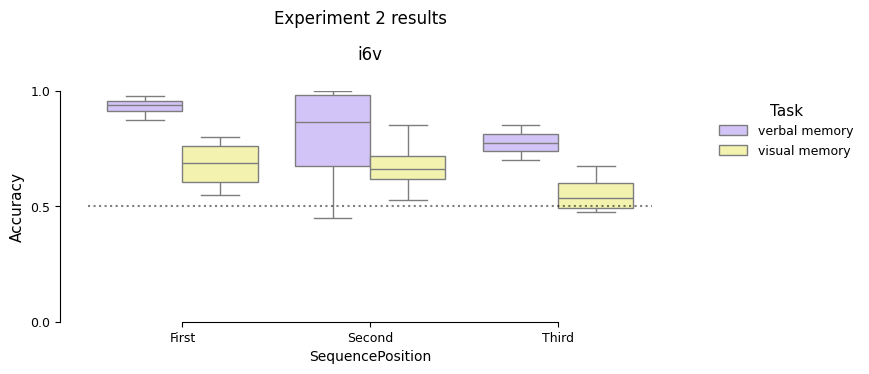

In [14]:
ax=plot_box_compare(experiment2DecodingResults, sns_kws=dict(hue_order = ['verbal memory','visual memory'], palette=sns.color_palette(['#d0bbff', '#fffea3'])))
plt.suptitle('Experiment 2 results',y=1.15)


In [15]:
def bootstrap_improvement_CI_by_position(experimentDecodingResults, n_resamples=10000, n_jobs=-1, seed = 42):
    """boostrapped estimate of CI for decoding accuracy by position. Each decoder's hits/misses are resampled and averaged to get one draw from the distribution of
    decoding accuracy for each position, task, and region. This is repeated many times to get a distribution of decoding accuracy for each position, task, and region.
    The 95% CI is then taken from this distribution as the 0.025 and 0.975 quantiles.

    Parameters
    ----------
    experimentDecodingResults : pandas.DataFrame
        prediction hits and misses for each decoder. each decoder is defined by the research task, brain region used to fit decoder,
        sequence position in which the two cues differ, and the two cues that differ in that position, and the fixed directions in the other sequence positions.

    n_resamples : int, optional
        number of times to resample for boostrapped estimate of CI, by default 1000
    n_jobs : int, optional
        number of cores to use for parallelized resampling, by default -1

    Returns
    -------
    pandas.DataFrame
        0.25, 0.5, and 0.975 quantiles of decoding accuracy for each position, task, and region
    """
    # set seed for consistency
    np.random.seed(seed)
    
    resampled_decoding_improvement_from_innerspeech_mentalstrategy = pd.concat(Parallel(n_jobs=n_jobs)(delayed(resample_paired_decoder_improvement_per_position)(experimentDecodingResults) for _ in range(n_resamples)))
    bootstrapped_CI_accuracy_by_position = resampled_decoding_improvement_from_innerspeech_mentalstrategy.groupby(['position','region']).quantile([.025, 0.5, 0.975]).reset_index()
    bootstrapped_CI_accuracy_by_position['quantile'] = bootstrapped_CI_accuracy_by_position['level_2']
    bootstrapped_CI_accuracy_by_position.drop('level_2',axis=1,inplace=True)
    return bootstrapped_CI_accuracy_by_position

def resample_paired_decoder_improvement_per_position(experimentDecodingResults):
    # resample each decoder individually
    experimentDecodingResultsResampled = experimentDecodingResults.groupby(['Task name','position','class0','class1','other_position_seq','region']).apply(resampled_each_decoder_hits_misses).reset_index().drop('level_6',axis=1)
    perDecoderAccuracyEstimate = experimentDecodingResultsResampled.groupby(['Task name','position','class0','class1','other_position_seq','region']).mean().reset_index()
    perDecoderAccuracyEstimate['Accuracy'] = perDecoderAccuracyEstimate['hits/misses']
    perDecoderAccuracyEstimate.drop('hits/misses',axis=1,inplace=True)
    pairedMentalStrategyDifference = perDecoderAccuracyEstimate.drop(['Task name', 'Accuracy'], axis=1).drop_duplicates().reset_index(drop=True) # this is just decoder metadata other than task
    pairedMentalStrategyDifference['decoding_accuracy_difference'] = perDecoderAccuracyEstimate.loc[perDecoderAccuracyEstimate['Task name']=='verbal memory','Accuracy'].values - perDecoderAccuracyEstimate.loc[perDecoderAccuracyEstimate['Task name']=='visual memory','Accuracy'].values
    # average over all changes in decoding per task and region
    return pairedMentalStrategyDifference.groupby(['position','region']).decoding_accuracy_difference.mean()

In [16]:
experiment2BootstrappedCI = bootstrap_improvement_CI_by_position(experiment2DecodingResults)


In [17]:
print("significant increase in decoding accuracy from engagement of inner speech for sequence recall:")
print(experiment2BootstrappedCI.query('quantile==0.025 & decoding_accuracy_difference>0'))
print()
print("all decoding accuracy improvements and confidence intervals:")
print(experiment2BootstrappedCI[experiment2BootstrappedCI['region']=='i6v'])

significant increase in decoding accuracy from engagement of inner speech for sequence recall:
   position region  decoding_accuracy_difference  quantile
0     First    i6v                       0.16875     0.025
6    Second    i6v                       0.03125     0.025
12    Third    i6v                       0.11875     0.025

all decoding accuracy improvements and confidence intervals:
   position region  decoding_accuracy_difference  quantile
0     First    i6v                       0.16875     0.025
1     First    i6v                       0.25000     0.500
2     First    i6v                       0.33125     0.975
6    Second    i6v                       0.03125     0.025
7    Second    i6v                       0.11875     0.500
8    Second    i6v                       0.20625     0.975
12    Third    i6v                       0.11875     0.025
13    Third    i6v                       0.21875     0.500
14    Third    i6v                       0.31875     0.975


In [18]:
experiment2DecodingAccuracy = experiment2DecodingResults.groupby(['Task name','region','position','class0','class1','other_position_seq'], dropna=False)['hits/misses'].mean().reset_index()
experiment2DecodingAccuracy['Accuracy'] = experiment2DecodingAccuracy['hits/misses']
experiment2DecodingAccuracy.drop('hits/misses',axis=1,inplace=True)

experiment2DecodingAccuracyImprovement = experiment2DecodingAccuracy.loc[experiment2DecodingAccuracy['Task name']=='verbal memory','region':'other_position_seq']

experiment2DecodingAccuracyImprovement['Accuracy'] = experiment2DecodingAccuracy.query('`Task name`=="verbal memory"').Accuracy.values - experiment2DecodingAccuracy.query('`Task name`=="visual memory"').Accuracy.values


In [19]:
experiment2DecodingAccuracyImprovement.groupby(['region','position']).Accuracy.mean()

region  position
i6v     First       0.25000
        Second      0.11875
        Third       0.21875
s6v     First       0.04375
        Second      0.04375
        Third      -0.05625
Name: Accuracy, dtype: float64

# Arrange all the plots together, leaving space for non data task descriptions

Text(0.5, 0, '')

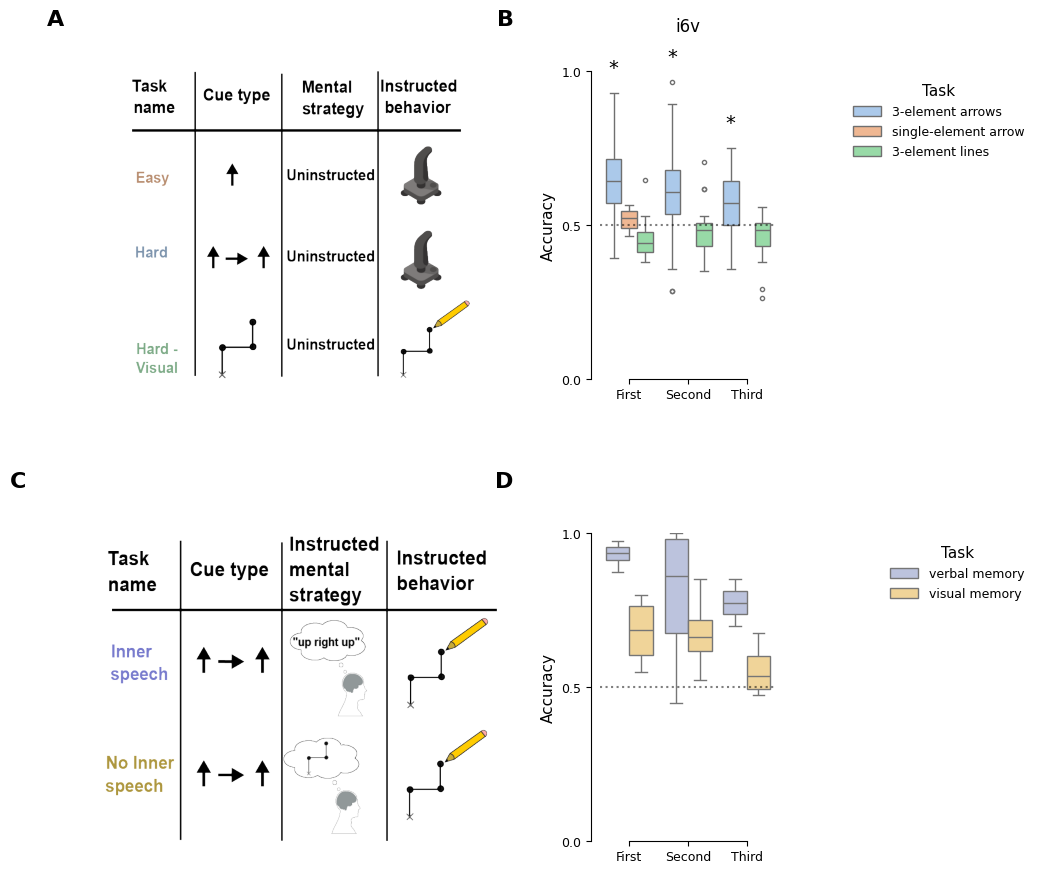

In [20]:
WIDTH_RATIOS = [3, 1]
WSPACE = 0
HSPACE = 0.5

# EXP1_COLORS = sns.color_palette([]) TODO
EXP2_COLORS = sns.color_palette(['#B7C0E2', '#FFD98A'])
EXP3_COLORS = sns.color_palette(['#4DA271', '#afd8c0'])
LEGEND_LOC = [2.3, 1]

fig = plt.figure(figsize=[10, 10], constrained_layout=False)
gs = fig.add_gridspec(2, 2, wspace=WSPACE, width_ratios=WIDTH_RATIOS, hspace=HSPACE)

# plot experiment 1
ax_tasks_exp1 = fig.add_subplot(gs[0, 0])
ax_tasks_exp1.imshow(plt.imread(FP_EXPERIMENT1_TASK))
ax_tasks_exp1.axis('off')
ax_tasks_exp1.text(-0.2, 1.2, 'A', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax_tasks_exp1.transAxes)

ax_exp1 = fig.add_subplot(gs[0, 1])
plot_box_compare(experiment1DecodingResults, ax=ax_exp1, legend_loc=LEGEND_LOC, 
                 experimentBootstrappedCI=experiment1BootstrappedCI,
                 x_pos_asterisk_offset=1.1, x_pos_asterisk_scale=0.25,
                 sns_kws={'palette': 'pastel', 'hue_order': ['3-element arrows', 'single-element arrow', '3-element lines']})
ax_exp1.text(-.4, 1.2, 'B', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax_exp1.transAxes)
ax_exp1.set_xlabel('')

# plot experiment 2
ax_tasks_exp2 = fig.add_subplot(gs[1, 0])
ax_tasks_exp2.imshow(plt.imread(FP_MENTAL_STRATEGY_SWAP_TASK))
ax_tasks_exp2.axis('off')
ax_tasks_exp2.text(-0.2, 1.2, 'C', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax_tasks_exp2.transAxes)

ax_exp2 = fig.add_subplot(gs[1, 1])
plot_box_compare(experiment2DecodingResults, ax=ax_exp2, legend_loc=LEGEND_LOC, 
                 sns_kws={'palette': EXP2_COLORS, 'hue_order': ['verbal memory', 'visual memory']},)
ax_exp2.set_title('')
ax_exp2.text(-0.4, 1.2, 'D', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax_exp2.transAxes)
ax_exp2.set_xlabel('')

# plt.savefig('../figures/Fig4.svg')


**Figure 4: Uninstructed inner speech elicited by a serial recall task can be decoded from i6v.**

**A)** T12 performed three upper extremity motor tasks with varied cues and memory demands to elicit verbal
short-term memory without explicit mental strategy instructions. The 3-element arrows task was designed
to prompt verbal memory (eliciting inner speech) for serial recall, while the single-element arrow and 3-
element lines tasks served as controls (designed not to elicit inner speech). **B)** Sequence position
decodability was measured by training binary Linear Discriminant Analysis models to classify sequence
pairs that differed in one position (e.g., first position: ↑ → ↑ vs ↓ → ↑) using i6v neural activity from a 2-
second delay period (pre-go) window. Box plots show cross-validated accuracy (dotted line indicates
chance). Only the 3-element arrows task produced significant decoding in all three positions (bootstrapderived
CIs vs chance level of 0.5). **C)** Two versions of the serial recall task with explicit instructions to use
either a verbal or visual short-term memory strategy (mental strategy instructions refer to how to memorize
the sequence, while instructed behavior refers to the motor output during recall). **D)** Same as B but for tasks
that only differed in instructed mental strategy. Decoding accuracy significantly increased in all sequence
positions when T12 engaged in a verbal memory strategy. Significance assessed via bootstrap-derived
confidence intervals of increase in decoding accuracy due to verbal memory instruction, compared to
chance level of zero (i.e. no difference between verbal and visual memory).

# Supplementary figures


## Experiment 3: Language Modulated Sequence Memorization
The final experiment tests whether the representations between inner speech and actual specking are similar between arrays. 

### Tasks
#### Task 1 Speech - speech reproduction

- cue: audio recording
- instructed behavior: attempted speech to reproduced the sequence of instructed words
- sequence elements : [”up”, “right”]
- sequence length: 3
- 20 trials per cue
- hypothesis: this task will require language to remember and reproduce the sequence, which will be represented in the delay period in 6v

#### Task 2 Inner speech - arrow cueing drawing

- cue: visual presentation of arrows in a sequence
- instructed behavior: draw  lines in this sequence without going back to center until the end of the trial. Also isntructed to use language to complete the task. Use optitrack to record the pen tip trajectories.
- instructed mental strategy is to use inner speech to remember the sequence
- has a return block
- sequence elements : [→, ↑]
- sequence length: 3
- 20 trials per cue
- hypothesis: this task will require language to remember and reproduce the sequence. Decoders from task 1 and 2 should generalize

In [21]:
speaking, channel_map_t12 = utils.assembleGoAlignedWin(FP_T12_SPEAK, utils.cueConditionsSpeak,
                                        ANALYSIS_WIN_DELAY)
speaking['task'] = 'attempted speech'

instructedInnerSpeech, channel_map_t12  = utils.assembleGoAlignedWin(FP_T12_ARROW, utils.cueConditionsInstructedInnerspeech,
                                        ANALYSIS_WIN_DELAY)
instructedInnerSpeech['task'] = 'verbal memory'

crossTaskData = pd.concat([speaking, instructedInnerSpeech])
crossTaskData['directionSeq'] = crossTaskData.First+' '+crossTaskData.Second+' '+crossTaskData.Third

# remove do nothing trials since not used in analysis
crossTaskData = crossTaskData[crossTaskData.cue!='DO_NOTHING']

In [22]:
# compute crossvalidated performance within and across tasks for decoding pairs of differences in sequences
x_val_folds = 5
tasks = crossTaskData.task.unique()
moveDirections = crossTaskData.dropna().First.unique()

crossTaskDecodingPerformance = []
for fit_task, test_task in [tasks, tasks[::-1]]:
    for region, channels in channel_map_t12.items():
        for position in SEQ_POS_COLS:
            other_positions = SEQ_POS_COLS[SEQ_POS_COLS!=position]
            # pairwise comparison so the only difference between sequences should be in the one position.
            for other_pos_value0, other_pos_value1 in product(moveDirections,repeat=2):
                thisItrIdx = np.logical_and(crossTaskData[other_positions[0]]==other_pos_value0,
                                            crossTaskData[other_positions[1]]==other_pos_value1)
                                                        
                fit_idx = np.logical_and(thisItrIdx,crossTaskData.task == fit_task)
                fitX = crossTaskData.loc[fit_idx,channels].values
                fitY = crossTaskData.loc[fit_idx,position].values

                test_idx = np.logical_and(thisItrIdx,crossTaskData.task == test_task)
                testX = crossTaskData.loc[test_idx,channels].values
                testY = crossTaskData.loc[test_idx,position].values

                kFolds = StratifiedKFold(n_splits = x_val_folds, random_state=42, shuffle=True)
                hits_misses = []
                for (trainSplit_index, _), (_, testSplit_index) in zip(kFolds.split(fitX,fitY),kFolds.split(testX,testY)):
                    clf.fit(fitX[trainSplit_index,:],fitY[trainSplit_index])
                    predictions = clf.predict(testX[testSplit_index])
                    hits_misses.append(predictions == testY[testSplit_index])
                
                performance = pd.DataFrame({'hits/misses':np.hstack(hits_misses),
                                        'position' :[position]*len(testY),
                                        'region'   :[region]*len(testY),
                                        'Task name':[f"{fit_task} → {test_task}"]*len(testY),
                                        'other_position_seq':[other_pos_value0+other_pos_value1]*len(testY)})
                crossTaskDecodingPerformance.append(performance)
crossTaskDecodingPerformance = pd.concat(crossTaskDecodingPerformance)
crossTaskDecodingPerformance['class0'] = '→' #  add for plotting function, only 2 directions so only one pair
crossTaskDecodingPerformance['class1'] = '↑'
crossTaskBootstrappedCI = bootstrap_accuracy_CI_by_position(crossTaskDecodingPerformance)


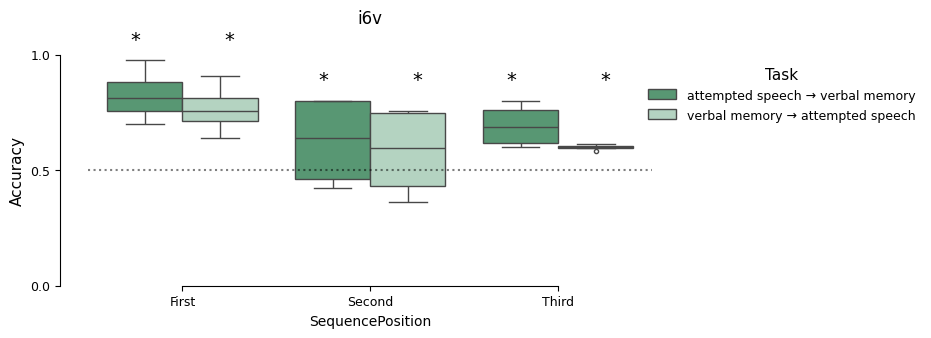

In [23]:
ax = plot_box_compare(crossTaskDecodingPerformance, 
                      experimentBootstrappedCI=crossTaskBootstrappedCI, 
                      sns_kws={'palette':sns.color_palette(['#4DA271', '#afd8c0']), 
                               'hue_order':['attempted speech → verbal memory','verbal memory → attempted speech']},
                    legend_loc=[1.4, 1])

In [24]:
print("significant decoding accuracies:")
print(crossTaskBootstrappedCI[(crossTaskBootstrappedCI['quantile']==0.025) & (crossTaskBootstrappedCI.Accuracy>0.5)])
print()
print("all decoding accuracies and confidence intervals:")
print(crossTaskBootstrappedCI)

significant decoding accuracies:
   position                         Task name region  Accuracy  quantile
0     First  attempted speech → verbal memory    i6v  0.768750     0.025
6     First  verbal memory → attempted speech    i6v  0.705882     0.025
12   Second  attempted speech → verbal memory    i6v  0.556250     0.025
18   Second  verbal memory → attempted speech    i6v  0.505882     0.025
24    Third  attempted speech → verbal memory    i6v  0.618750     0.025
30    Third  verbal memory → attempted speech    i6v  0.523529     0.025

all decoding accuracies and confidence intervals:
   position                         Task name region  Accuracy  quantile
0     First  attempted speech → verbal memory    i6v  0.768750     0.025
1     First  attempted speech → verbal memory    i6v  0.825000     0.500
2     First  attempted speech → verbal memory    i6v  0.881250     0.975
3     First  attempted speech → verbal memory    s6v  0.500000     0.025
4     First  attempted speech → verbal m

## Figure S2: attempted speech representation generalizes to verbal instructed mental strategy of serial recall
The final experiment tests whether the representations between inner speech and actual specking are similar between arrays. 

### Tasks
#### Task 1 Speech - speech reproduction

- cue: audio recording
- instructed behavior: attempted speech to reproduced the sequence of instructed words
- sequence elements : [”up”, “right”]
- sequence length: 3
- 20 trials per cue
- hypothesis: this task will require language to remember and reproduce the sequence, which will be represented in the delay period in 6v

#### Task 2 Inner speech - arrow cueing drawing

- cue: visual presentation of arrows in a sequence
- instructed behavior: draw  lines in this sequence without going back to center until the end of the trial. Also isntructed to use language to complete the task. Use optitrack to record the pen tip trajectories.
- instructed mental strategy is to use inner speech to remember the sequence
- has a return block
- sequence elements : [→, ↑]
- sequence length: 3
- 20 trials per cue
- hypothesis: this task will require language to remember and reproduce the sequence. Decoders from task 1 and 2 should generalize

In [25]:
speaking, channel_map_t12 = utils.assembleGoAlignedWin(FP_T12_SPEAK, utils.cueConditionsSpeak,
                                        ANALYSIS_WIN_DELAY)
speaking['task'] = 'attempted speech'

instructedInnerSpeech, channel_map_t12  = utils.assembleGoAlignedWin(FP_T12_ARROW, utils.cueConditionsInstructedInnerspeech,
                                        ANALYSIS_WIN_DELAY)
instructedInnerSpeech['task'] = 'verbal memory'

crossTaskData = pd.concat([speaking, instructedInnerSpeech])
crossTaskData['directionSeq'] = crossTaskData.First+' '+crossTaskData.Second+' '+crossTaskData.Third

# remove do nothing trials since not used in analysis
crossTaskData = crossTaskData[crossTaskData.cue!='DO_NOTHING']

In [26]:
# compute crossvalidated performance within and across tasks for decoding pairs of differences in sequences
x_val_folds = 5
tasks = crossTaskData.task.unique()
moveDirections = crossTaskData.dropna().First.unique()

crossTaskDecodingPerformance = []
for fit_task, test_task in [tasks, tasks[::-1]]:
    for region, channels in channel_map_t12.items():
        for position in SEQ_POS_COLS:
            other_positions = SEQ_POS_COLS[SEQ_POS_COLS!=position]
            # pairwise comparison so the only difference between sequences should be in the one position.
            for other_pos_value0, other_pos_value1 in product(moveDirections,repeat=2):
                thisItrIdx = np.logical_and(crossTaskData[other_positions[0]]==other_pos_value0,
                                            crossTaskData[other_positions[1]]==other_pos_value1)
                                                        
                fit_idx = np.logical_and(thisItrIdx,crossTaskData.task == fit_task)
                fitX = crossTaskData.loc[fit_idx,channels].values
                fitY = crossTaskData.loc[fit_idx,position].values

                test_idx = np.logical_and(thisItrIdx,crossTaskData.task == test_task)
                testX = crossTaskData.loc[test_idx,channels].values
                testY = crossTaskData.loc[test_idx,position].values

                kFolds = StratifiedKFold(n_splits = x_val_folds, random_state=42, shuffle=True)
                hits_misses = []
                for (trainSplit_index, _), (_, testSplit_index) in zip(kFolds.split(fitX,fitY),kFolds.split(testX,testY)):
                    clf.fit(fitX[trainSplit_index,:],fitY[trainSplit_index])
                    predictions = clf.predict(testX[testSplit_index])
                    hits_misses.append(predictions == testY[testSplit_index])
                
                performance = pd.DataFrame({'hits/misses':np.hstack(hits_misses),
                                        'position' :[position]*len(testY),
                                        'region'   :[region]*len(testY),
                                        'Task name':[f"{fit_task} → {test_task}"]*len(testY),
                                        'other_position_seq':[other_pos_value0+other_pos_value1]*len(testY)})
                crossTaskDecodingPerformance.append(performance)
crossTaskDecodingPerformance = pd.concat(crossTaskDecodingPerformance)
crossTaskDecodingPerformance['class0'] = '→' #  add for plotting function, only 2 directions so only one pair
crossTaskDecodingPerformance['class1'] = '↑'
crossTaskBootstrappedCI = bootstrap_accuracy_CI_by_position(crossTaskDecodingPerformance)


Text(0, 0.5, 'Cross-task\nAccuracy')

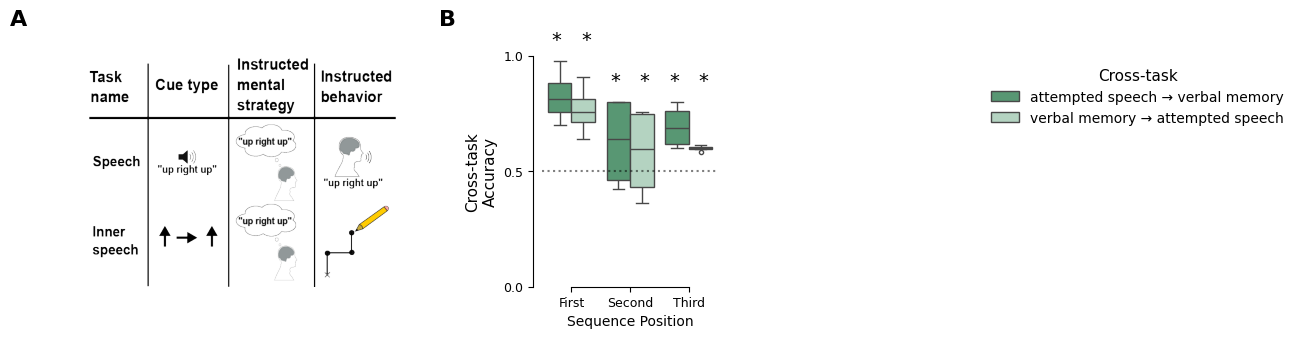

In [27]:
fig = plt.figure(figsize=[10, 3], constrained_layout=False)
gs = fig.add_gridspec(1, 2, wspace=WSPACE, width_ratios=WIDTH_RATIOS, hspace=HSPACE)

ax_tasks_exp3 = fig.add_subplot(gs[0, 0])
ax_tasks_exp3.imshow(plt.imread(FP_GENERALIZE_TASK))
ax_tasks_exp3.axis('off')
ax_tasks_exp3.text(-0.2, 1.2, 'A', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax_tasks_exp3.transAxes)

ax_exp3 = fig.add_subplot(gs[0, 1])
plot_box_compare(crossTaskDecodingPerformance, ax=ax_exp3, legend_loc=LEGEND_LOC, 
                 experimentBootstrappedCI=crossTaskBootstrappedCI,
                 sns_kws={'palette': EXP3_COLORS,'hue_order':['attempted speech → verbal memory','verbal memory → attempted speech']})
ax_exp3.set_title('')
ax_exp3.set_xlabel('Sequence Position')
ax_exp3.text(-0.4, 1.2, 'B', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax_exp3.transAxes)

ax_exp3.legend(bbox_to_anchor=LEGEND_LOC, frameon=False).set_title('Cross-task', prop={'size': 11})
ax_exp3.set_ylabel('Cross-task\nAccuracy')

In [28]:
print("significant decoding accuracies:")
print(crossTaskBootstrappedCI[(crossTaskBootstrappedCI['quantile']==0.025) & (crossTaskBootstrappedCI.Accuracy>0.5)])

significant decoding accuracies:
   position                         Task name region  Accuracy  quantile
0     First  attempted speech → verbal memory    i6v  0.768750     0.025
6     First  verbal memory → attempted speech    i6v  0.705882     0.025
12   Second  attempted speech → verbal memory    i6v  0.550000     0.025
18   Second  verbal memory → attempted speech    i6v  0.505882     0.025
21   Second  verbal memory → attempted speech    s6v  0.505882     0.025
24    Third  attempted speech → verbal memory    i6v  0.625000     0.025
30    Third  verbal memory → attempted speech    i6v  0.529412     0.025


**Figure S2: Shared representation of spoken direction words and verbal memory of a motor
sequence.**
**A)** An attempted speaking task was compared to a motor sequence task where participant T12 was
instructed to use verbal memory to remember the sequence. **B)** The same decoding analysis described in
Figure 4B is shown for decoders trained on attempted speech and tested on verbal memory (or vice versa)
to assess whether the representation of verbal short term memory and spoken direction words is shared.
Box plots show cross-validated accuracy (dotted line indicates chance) and asterisks indicate above chance
performance per position as assessed via a bootstrap-derived 95% CIs compared to chance level of 0.5.

## Figure S3

In [29]:
## experiment 1: uninstructed inner speeech strategy
FP_UNINSTRUCTED_ARROWSEQ_T16 = os.path.join(DIR_DATA, 'seqRecallUninstructed3ElementArrow', 't16.2024.04.08_binnedTX_spikePow_20ms.mat')
FP_UNINSTRUCTED_LINESEQ_T16 = os.path.join(DIR_DATA, 'seqRecallUninstructed3ElementLines', 't16.2024.04.08_binnedTX_spikePow_20ms_lines.mat')

## Experiment 2: instructed mental strategy switch
FP_ARROW_INSTRUCTED_VERBAL_T16 = os.path.join(DIR_DATA, 'seqRecallVerbalMemory','t16.2024.07.17_binnedTX_spikePow_20ms_verbal.mat')
FP_ARROW_INSTRUCTED_VISUAL_T16 = os.path.join(DIR_DATA, 'seqRecallVisualMemory','t16.2024.07.17_binnedTX_spikePow_20ms_visual.mat')

## Experiment 3: inner speech and speech similarity.
FP_SPEAKING_T16 = os.path.join(DIR_DATA, 'seqRecallSpeech','t16.2024.07.17_binnedTX_spikePow_20ms.mat')

# for T16 the optimal window was the first 0.75s after the go cue
ANALYSIS_WIN_T16 = [0,.75]


TRIAL_WIN = [-50, 100]
CHANNEL_SETS_T16 = {
             'i6v' : np.arange(64,128),
             '6d' : np.arange(128,256)}

In [ ]:
def sumWindowedData(windowedDf, analysisWin, areas):
    analysisWinIdx = np.logical_and(windowedDf.Misc['time(s)']>=analysisWin[0], 
                                    windowedDf.Misc['time(s)']<=analysisWin[1])
    analysisWinDf = windowedDf[analysisWinIdx]
    summed = analysisWinDf.groupby(('Misc','trial')).sum()[areas]
    trial_metadata = analysisWinDf[['SequencePosition','Misc']].drop(('Misc','time(s)'),axis=1).drop_duplicates().set_index(('Misc','trial'))
    summedWin = summed.merge(trial_metadata,left_index=True,right_index=True).droplevel(level=0,axis=1)
    return summedWin


### Experiment 1 with T16

In [31]:
windowed_uninstructed_arrows_t16 = utils.assemble_trials_metadata_T16(FP_UNINSTRUCTED_ARROWSEQ_T16,CHANNEL_SETS_T16,
                                                    utils.cueConditionsArrowSeq_T16, TRIAL_WIN,
                                                    )
windowed_uninstructed_lines_t16  = utils.assemble_trials_metadata_T16(FP_UNINSTRUCTED_LINESEQ_T16,CHANNEL_SETS_T16,
                                                       utils.cueConditionsUninstructedLines_T16, TRIAL_WIN,
                                                       )
windowed_uninstructed_arrows_t16[('Misc','task')] = '3-element arrows'
windowed_uninstructed_lines_t16[('Misc','task')] = '3-element lines'

windowed_all_tasks_exp2_t16 = pd.concat([windowed_uninstructed_arrows_t16, windowed_uninstructed_lines_t16])

mismatch in expected and actual trial duration for trial 159. Expected 150 bins, got 149 bins
mismatch in expected and actual trial duration for trial 159. Expected 150 bins, got 149 bins


In [46]:
windowed_uninstructed_arrows_t16

i6v                                                              \
       ch64_tx   ch65_tx   ch66_tx   ch67_tx   ch68_tx   ch69_tx   ch70_tx   
0    -0.659741 -0.262064 -0.154123  0.476309 -1.109490 -1.087927 -0.426516   
1    -0.058401 -1.285097  0.203467  0.985221 -1.109490 -0.256455 -0.426516   
2     0.542939  2.807036  1.633827 -0.032604 -0.417759  2.237960 -0.426516   
3     0.542939  1.101980  0.918647  0.221853 -1.109490 -1.087927 -0.426516   
4    -0.659741  0.419958 -0.154123 -0.032604  0.965702  0.575017 -0.426516   
...        ...       ...       ...       ...       ...       ...       ...   
4795 -1.276595  0.286428 -1.200140 -0.381446 -0.359760  1.444624 -0.418960   
4796 -1.276595  1.309461 -0.842550 -0.890358 -1.051490 -1.049792  3.095618   
4797 -0.073915  1.650472  0.587811 -0.635902  1.023701 -1.049792 -0.418960   
4798 -0.073915  1.309461 -1.200140 -0.126990  1.023701 -0.218320  1.338329   
4799 -0.675255  1.991483 -0.842550 -0.635902  2.407162 -0.218320 -0.418960   

                                    ...        6d           PhonemePosition  \
       ch71_tx   ch72_tx   ch73_tx  ...  ch254_sp  ch255_sp           First   
0    -0.292163 -0.326250 -1.158712  ... -0.611161 -0.340658               ↑   
1    -0.292163  0.638566  1.211386  ...  0.187914  0.283648               ↑   
2    -0.292163  1.120974  0.026337  ...  0.151068 -1.152142               ↑   
3    -0.292163  2.085790  1.211386  ... -0.148819 -0.819397               ↑   
4    -0.292163  0.638566  0.421354  ... -0.443968  0.011037               ↑   
...        ...       ...       ...  ...       ...       ...             ...   
4795 -0.104166 -1.085920 -0.848338  ... -0.096149 -0.809679               ↑   
4796 -0.104166 -0.121104 -0.848338  ...  0.627337 -1.149926               ↑   
4797 -0.104166  1.326120  1.521760  ... -0.908335 -1.580055               ↑   
4798 -0.104166 -0.603512 -0.848338  ... -1.030827  0.146472               ↑   
4799 -0.104166 -1.085920 -0.058305  ... -1.739243 -2.205492               ↑   

                     Misc                                        
     Second Third time(s) cue_id    cue trial              task  
0         →     →    -1.0    3.0  ↑ → →     0  3-element arrows  
1         →     →    -0.9    3.0  ↑ → →     0  3-element arrows  
2         →     →    -0.8    3.0  ↑ → →     0  3-element arrows  
3         →     →    -0.7    3.0  ↑ → →     0  3-element arrows  
4         →     →    -0.6    3.0  ↑ → →     0  3-element arrows  
...     ...   ...     ...    ...    ...   ...               ...  
4795      →     →     1.5    3.0  ↑ → →   159  3-element arrows  
4796      →     →     1.6    3.0  ↑ → →   159  3-element arrows  
4797      →     →     1.7    3.0  ↑ → →   159  3-element arrows  
4798      →     →     1.8    3.0  ↑ → →   159  3-element arrows  
4799      →     →     1.9    3.0  ↑ → →   159  3-element arrows  

[4800 rows x 392 columns]

In [32]:
def decodePerPosition_T16(windowed_task_df, analysisWin, x_val_folds=10, areas = ['i6v', '6d']):
    decodingPerformance = []
    sum_task_df = sumWindowedData(windowed_task_df, analysisWin, areas)
    for area in areas:
        channels = windowed_task_df[area].columns
        for position in SEQ_POS_COLS:
            other_positions = SEQ_POS_COLS[SEQ_POS_COLS!=position]
            other_position_values = sum_task_df[other_positions].sum(axis=1).unique()

            # pairwise comparison so the only difference between sequences should be in the one position.
            for other_pos_value0, other_pos_value1 in other_position_values:
                # only do two-way decoding so that chance is at 50%
                seqIdx = np.logical_and(sum_task_df[other_positions[0]]==other_pos_value0, 
                                        sum_task_df[other_positions[1]]==other_pos_value1)
                moveDirections = sum_task_df.loc[seqIdx, position].unique()
                for classes in combinations(moveDirections,r=2):
                    class0, class1 = np.sort(classes)
                    positionDecodePerformance = decodeSingelMoveDir(sum_task_df, channels, position, class0, class1, 
                                                        other_positions, other_pos_value0, other_pos_value1, 
                                                        area, x_val_folds=x_val_folds)
                    decodingPerformance.append(positionDecodePerformance)
    return pd.concat(decodingPerformance)

def plot_box_compare_multiregion(experimentDecodingResults, regions = ['i6v','s6v'], axs=None, sns_kws={}, rot=0, 
                     ylabelsize=11, ticklabelsize=9, legendsize=9, legendtitlesize=11,legend_loc=[4.5,1],
                     experimentBootstrappedCI=None, chance_performance = 0.5, x_pos_asterisk_offset=0.5):
    if axs is None:
        f, axs = plt.subplots(1,len(regions),figsize=[8,3])
    
    # get accuracy for plotting:
    experimentDecodingAccuracy = experimentDecodingResults.groupby(['position','class0','class1','other_position_seq','region','Task name'],dropna=False).mean().reset_index()
    experimentDecodingAccuracy['Accuracy'] = experimentDecodingAccuracy['hits/misses']
    
    for axIdx, region in enumerate(regions):
        if axIdx == 0:
            legend=True
        else:
            legend=False
        
        sns.boxplot(data=experimentDecodingAccuracy[experimentDecodingAccuracy.region==region], 
                    x='position', y='Accuracy', hue='Task name',
                    ax=axs[axIdx], legend=legend, fliersize=3, **sns_kws)
        
        axs[axIdx].set_title(region)

    if type(experimentBootstrappedCI) is pd.DataFrame:
            # Adding significance asterisks
            for axIdx, region in enumerate(regions):
                for position_idx, position in enumerate(experimentDecodingAccuracy['position'].unique()):
                    for task_idx, task_name in enumerate(experimentDecodingAccuracy['Task name'].unique()):
                        # Get the CI data for this region, position, and task
                        ci_data = experimentBootstrappedCI[
                                (experimentBootstrappedCI['position'] == position) & 
                                (experimentBootstrappedCI['region'] == region) & 
                                (experimentBootstrappedCI['Task name'] == task_name)
                            ]
                            
                        if not ci_data.empty:
                            lower_bound = ci_data[ci_data['quantile'] == 0.025]['Accuracy'].values[0]
                            
                            # If the confidence interval does not overlap with chance, add an asterisk
                            if lower_bound > chance_performance:
                                x_pos = position_idx + (task_idx -0.5)*x_pos_asterisk_offset
                                y_pos = experimentDecodingAccuracy[
                                    (experimentDecodingAccuracy['position'] == position) & 
                                    (experimentDecodingAccuracy['region'] == region)
                                ]['Accuracy'].max()
                                
                                axs[axIdx].text(x_pos, y_pos + 0.05, '*', ha='center', va='bottom', color='black', fontsize=14)
    
    for i, ax in enumerate(axs):
        if i > 0:
            left = True
            ax.set_yticks([])
            ax.set_ylabel('')
        else:
            left = False
            ax.set_yticks([0, 0.5, 1])
            ax.set_ylabel(ax.get_ylabel(), fontsize=ylabelsize)

        sns.despine(trim=True, ax=ax, left=left)
        ax.set_xlabel('')
        ax.set_ylim(0, 1)
        xmin, xmax = ax.get_xlim()
        ax.hlines(0.5, xmin, xmax, color='k', ls=':', alpha=0.5)

        # Set font sizes
        ax.tick_params(axis='both', labelsize=ticklabelsize)
        ax.set_ylim(0, 1)

    legend = axs[0].legend(bbox_to_anchor=legend_loc, frameon=False)
    
    for text in legend.texts:
        text.set_fontsize(legendsize)
    legend.set_title('Task', prop={'size': legendtitlesize})

    return axs

In [33]:
decoded_uninstructed_arrows_t16 = decodePerPosition_T16(windowed_uninstructed_arrows_t16, ANALYSIS_WIN_T16)
decoded_uninstructed_lines_t16  = decodePerPosition_T16(windowed_uninstructed_lines_t16, ANALYSIS_WIN_T16)
decoded_uninstructed_arrows_t16['Task name'] = '3-element arrows'
decoded_uninstructed_lines_t16['Task name'] = '3-element lines'
experiment1DecodingResultsT16 = pd.concat([decoded_uninstructed_arrows_t16, decoded_uninstructed_lines_t16])
experiment1BootstrappedCIT16 = bootstrap_accuracy_CI_by_position(experiment1DecodingResultsT16)

significant decoding accuracies:
  position         Task name region  Accuracy  quantile
0    First  3-element arrows     6d   0.70000     0.025
3    First  3-element arrows    i6v   0.53125     0.025
6    First   3-element lines     6d   0.65000     0.025

All decoding acuracies and confidence intervals:
   position         Task name region  Accuracy  quantile
0     First  3-element arrows     6d   0.70000     0.025
1     First  3-element arrows     6d   0.76250     0.500
2     First  3-element arrows     6d   0.82500     0.975
3     First  3-element arrows    i6v   0.53125     0.025
4     First  3-element arrows    i6v   0.60625     0.500
5     First  3-element arrows    i6v   0.68125     0.975
6     First   3-element lines     6d   0.65000     0.025
7     First   3-element lines     6d   0.71875     0.500
8     First   3-element lines     6d   0.78750     0.975
9     First   3-element lines    i6v   0.48125     0.025
10    First   3-element lines    i6v   0.55625     0.500
11    Fir

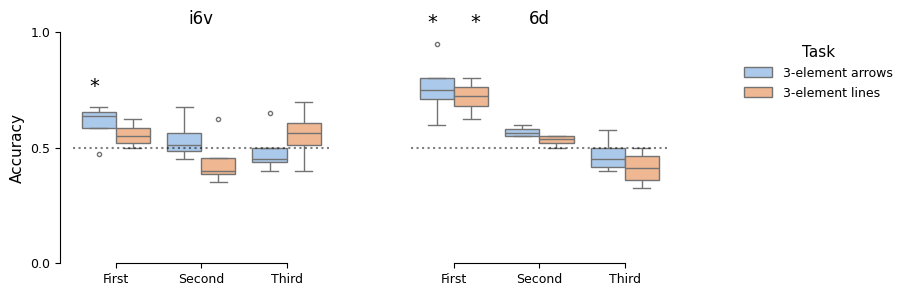

In [34]:
axs = plot_box_compare_multiregion(experiment1DecodingResultsT16, regions = ['i6v', '6d'], legend_loc=[3,1],
                                   experimentBootstrappedCI=experiment1BootstrappedCIT16,
                                   sns_kws=dict(hue_order = ['3-element arrows', '3-element lines'], palette='pastel'))

print("significant decoding accuracies:")
print(experiment1BootstrappedCIT16[(experiment1BootstrappedCIT16['quantile']==0.025) & (experiment1BootstrappedCIT16.Accuracy>0.5)])
print()
print('All decoding acuracies and confidence intervals:')
print(experiment1BootstrappedCIT16)

### Experiment 2 with T16

In [35]:
windowed_inner_speech_t16   = utils.assemble_trials_metadata_T16(FP_ARROW_INSTRUCTED_VERBAL_T16,CHANNEL_SETS_T16,
                                                    utils.cueConditionsArrowSeq_T16, TRIAL_WIN,
                                                    )
windowed_no_inner_speech_t16 = utils.assemble_trials_metadata_T16(FP_ARROW_INSTRUCTED_VISUAL_T16,CHANNEL_SETS_T16,
                                                       utils.cueConditionsArrowSeq_T16, TRIAL_WIN,
                                                       )
windowed_inner_speech_t16[('Misc','mental_strategy')] = 'verbal memory'
windowed_no_inner_speech_t16[('Misc','mental_strategy')] = 'visual memory'
windowed_inner_speech_t16[('Misc','task')] = 'verbal memory'
windowed_no_inner_speech_t16[('Misc','task')] = 'visual memory'

windowed_all_tasks_exp2_t16 = pd.concat([windowed_inner_speech_t16, windowed_no_inner_speech_t16])

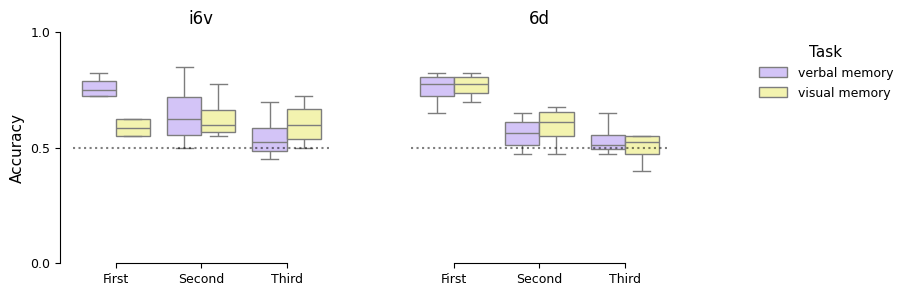

In [36]:
decoded_innerspeech_t16 =   decodePerPosition_T16(windowed_inner_speech_t16, ANALYSIS_WIN_T16)
decoded_noinnerspeech_t16 = decodePerPosition_T16(windowed_no_inner_speech_t16, ANALYSIS_WIN_T16)
decoded_innerspeech_t16['Task name'] = 'verbal memory'
decoded_noinnerspeech_t16['Task name'] = 'visual memory'
experiment2DecodingResultsT16 = pd.concat([decoded_innerspeech_t16, decoded_noinnerspeech_t16])
axs = plot_box_compare_multiregion(experiment2DecodingResultsT16, regions = ['i6v', '6d'], legend_loc=[3,1],
                                                           sns_kws=dict(hue_order = ['verbal memory','visual memory'], 
                                                                        palette=sns.color_palette(['#d0bbff', '#fffea3'])
                                                                        )
                                   )

In [37]:
experiment2BootstrappedCI_testmetric_t16 = bootstrap_improvement_CI_by_position(experiment2DecodingResultsT16)
print("significant decoding accuracies:")
print(experiment2BootstrappedCI_testmetric_t16[(experiment2BootstrappedCI_testmetric_t16['quantile']==0.025) & (experiment2BootstrappedCI_testmetric_t16.decoding_accuracy_difference>0)])
print("all decoding accuracies:")
print(experiment2BootstrappedCI_testmetric_t16)

significant decoding accuracies:
  position region  decoding_accuracy_difference  quantile
3    First    i6v                         0.075     0.025
all decoding accuracies:
   position region  decoding_accuracy_difference  quantile
0     First     6d                      -0.10625     0.025
1     First     6d                      -0.01250     0.500
2     First     6d                       0.08125     0.975
3     First    i6v                       0.07500     0.025
4     First    i6v                       0.17500     0.500
5     First    i6v                       0.27500     0.975
6    Second     6d                      -0.13750     0.025
7    Second     6d                      -0.03125     0.500
8    Second     6d                       0.07500     0.975
9    Second    i6v                      -0.08125     0.025
10   Second    i6v                       0.01875     0.500
11   Second    i6v                       0.11875     0.975
12    Third     6d                      -0.06875     0.025


### Experiment 3 with T16

In [38]:
windowed_speaking_t16 = utils.assemble_trials_metadata_T16(FP_SPEAKING_T16,CHANNEL_SETS_T16,
                                                utils.cueConditionsSpeakingT16, TRIAL_WIN,
                                                )
windowed_speaking_t16[('Misc','task')] = 'speaking'

speaking_T16 = sumWindowedData(windowed_speaking_t16, ANALYSIS_WIN_T16, CHANNEL_SETS_T16.keys())
# remove any do nothing trials
speaking_T16 = speaking_T16[speaking_T16.cue!='Do Nothing']
inner_speech_t16 = sumWindowedData(windowed_inner_speech_t16, ANALYSIS_WIN_T16, CHANNEL_SETS_T16.keys())

crossTaskDataT16 = pd.concat([speaking_T16, inner_speech_t16])

mismatch in expected and actual trial duration for trial 59. Expected 150 bins, got 149 bins
mismatch in expected and actual trial duration for trial 59. Expected 150 bins, got 149 bins


In [39]:
# no xval but when fitting to inner speech do it pairwise with controlled other positions and always test on same speech
# reverse for inner speech, train on same speech and test on pairwise. 
# seems a bit odd but it's the closest I can do to T12 analysis.
x_val_folds=4
classification_algorithm = LinearDiscriminantAnalysis

# first train on inner speech, test on speech
crossTaskDecodingPerformanceT16 = []
for region in ['i6v', '6d']:
    channels = windowed_inner_speech_t16[region].columns
    for position in SEQ_POS_COLS:
        other_positions = SEQ_POS_COLS[SEQ_POS_COLS!=position]
        other_position_values = inner_speech_t16[other_positions].sum(axis=1).unique()
        for other_pos_value0, other_pos_value1 in other_position_values:
            # only do two-way decoding so that chance is at 50%
            seqIdx = np.logical_and(inner_speech_t16[other_positions[0]]==other_pos_value0, 
                                    inner_speech_t16[other_positions[1]]==other_pos_value1)

            fitInnerSpeechX = inner_speech_t16.loc[seqIdx,channels].values
            fitInnerSpeechY = inner_speech_t16.loc[seqIdx,position].values

            testSpeechX = speaking_T16[channels].values
            testSpeechY = speaking_T16['First'].values
            
            kFolds = StratifiedKFold(n_splits = x_val_folds, random_state=42, shuffle=True)
            hits_misses = []
            for (trainSplit_index, _), (_, testSplitIdx) in zip(kFolds.split(fitInnerSpeechX,fitInnerSpeechY), kFolds.split(testSpeechX, testSpeechY)):
                # throw out test indices because we're testing across task generalization
                clf = classification_algorithm()
                clf.fit(fitInnerSpeechX[trainSplit_index,:],fitInnerSpeechY[trainSplit_index])

                predictions = clf.predict(testSpeechX[testSplitIdx,:])
                hits_misses.append(predictions == testSpeechY[testSplitIdx])
            
            performance = pd.DataFrame({'hits/misses':np.hstack(hits_misses),
                                    'position':[position]*len(testSpeechY),
                                    'other_position_seq':[other_pos_value0+other_pos_value1]*len(testSpeechY),
                                    'region':[region]*len(testSpeechY),
                                    'Task name':["verbal memory → attempted speech"]*len(testSpeechY)})

            crossTaskDecodingPerformanceT16.append(performance)

for region in ['i6v', '6d']:
    channels = windowed_inner_speech_t16[region].columns
    for position in SEQ_POS_COLS:
        other_positions = SEQ_POS_COLS[SEQ_POS_COLS!=position]
        other_position_values = inner_speech_t16[other_positions].sum(axis=1).unique()
        for other_pos_value0, other_pos_value1 in other_position_values:
            seqIdx = np.logical_and(inner_speech_t16[other_positions[0]]==other_pos_value0, 
                                    inner_speech_t16[other_positions[1]]==other_pos_value1)

            fitSpeechX = speaking_T16[channels].values
            fitSpeechY = speaking_T16['First'].values
            
            testInnerSpeechX = inner_speech_t16.loc[seqIdx,channels].values
            testInnerSpeechY = inner_speech_t16.loc[seqIdx,position].values

            kFolds = StratifiedKFold(n_splits = x_val_folds, random_state=42, shuffle=True)
            hits_misses = []
            for (trainSplit_index, _), (_, testSplitIdx) in zip(kFolds.split(fitSpeechX,fitSpeechY), kFolds.split(testInnerSpeechX, testInnerSpeechY)):
                clf = classification_algorithm()
                clf.fit(fitSpeechX[trainSplit_index,:],fitSpeechY[trainSplit_index])

                predictions = clf.predict(testInnerSpeechX[testSplitIdx,:])
                hits_misses.append(predictions == testInnerSpeechY[testSplitIdx])
            
            performance = pd.DataFrame({'hits/misses':np.hstack(hits_misses),
                                    'position':[position]*len(testInnerSpeechY),
                                    'other_position_seq':[other_pos_value0+other_pos_value1]*len(testInnerSpeechY),
                                    'region':[region]*len(testInnerSpeechY),
                                    'Task name':["attempted speech → verbal memory"]*len(testInnerSpeechY)})

            crossTaskDecodingPerformanceT16.append(performance)

crossTaskDecodingPerformanceT16 = pd.concat(crossTaskDecodingPerformanceT16)
crossTaskDecodingPerformanceT16['class0'] = '→'
crossTaskDecodingPerformanceT16['class1'] = '↑'
experiment3BootstrappedCIT16 = bootstrap_accuracy_CI_by_position(crossTaskDecodingPerformanceT16)

In [40]:
crossTaskDecodingPerformanceT16

,hits/misses,position,other_position_seq,region,Task name,class0,class1
0,True,First,→↑,i6v,verbal memory → attempted speech,→,↑
1,True,First,→↑,i6v,verbal memory → attempted speech,→,↑
2,False,First,→↑,i6v,verbal memory → attempted speech,→,↑
3,True,First,→↑,i6v,verbal memory → attempted speech,→,↑
4,False,First,→↑,i6v,verbal memory → attempted speech,→,↑
...,...,...,...,...,...,...,...
35,True,Third,→↑,6d,attempted speech → verbal memory,→,↑
36,True,Third,→↑,6d,attempted speech → verbal memory,→,↑
37,True,Third,→↑,6d,attempted speech → verbal memory,→,↑
38,False,Third,→↑,6d,attempted speech → verbal memory,→,↑


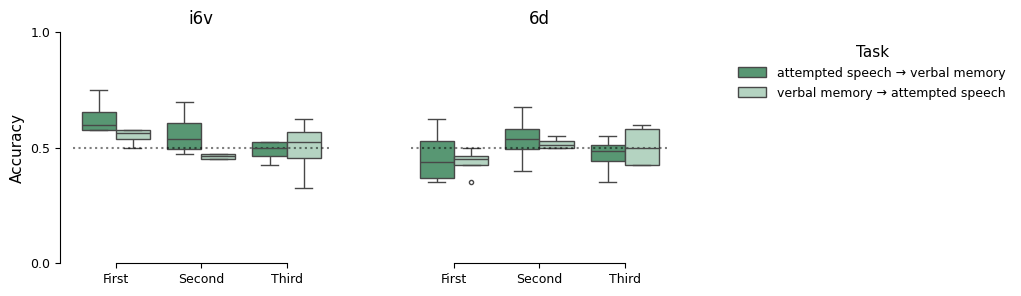

In [41]:

ax = plot_box_compare_multiregion(crossTaskDecodingPerformanceT16,legend_loc=[3.4,1],
                                #   experimentBootstrappedCI=experiment3BootstrappedCI,x_pos_asterisk_offset=0.5,
                                  sns_kws={'palette':sns.color_palette(['#4DA271', '#afd8c0'])}, regions = ['i6v', '6d'])


### Combine into final figure

In [42]:
# join T16 and T12 results with regions named with participants. 
experiment1DecodingResultsT12 = experiment1DecodingResults.copy()
experiment2DecodingResultsT12 = experiment2DecodingResults.copy()
crossTaskDecodingPerformanceT12 = crossTaskDecodingPerformance.copy()
experiment1DecodingResultsT12['region'] = 'T12-' + experiment1DecodingResultsT12['region']
experiment2DecodingResultsT12['region'] = 'T12-' + experiment2DecodingResultsT12['region']
crossTaskDecodingPerformanceT12['region'] = 'T12-' + crossTaskDecodingPerformanceT12['region']

experiment1DecodingResultsT16['region'] = 'T16-' + experiment1DecodingResultsT16['region']
experiment2DecodingResultsT16['region'] = 'T16-' + experiment2DecodingResultsT16['region']
crossTaskDecodingPerformanceT16['region'] = 'T16-' + crossTaskDecodingPerformanceT16['region']

experiment1DecodingResults_both_participants = pd.concat([experiment1DecodingResultsT16, experiment1DecodingResultsT12])
experiment2DecodingResults_both_participants = pd.concat([experiment2DecodingResultsT16, experiment2DecodingResultsT12])
crossTaskDecodingPerformance_both_participants = pd.concat([crossTaskDecodingPerformanceT16, crossTaskDecodingPerformanceT12])


In [43]:
experiment1BootstrappedCI_both_participants = bootstrap_accuracy_CI_by_position(experiment1DecodingResults_both_participants)
experiment2BootstrappedCI_testmetric_both_participants = bootstrap_improvement_CI_by_position(experiment2DecodingResults_both_participants)
experiment3BootstrappedCI_both_participants = bootstrap_accuracy_CI_by_position(crossTaskDecodingPerformance_both_participants)

Text(0.5, 0, 'Sequence Position')

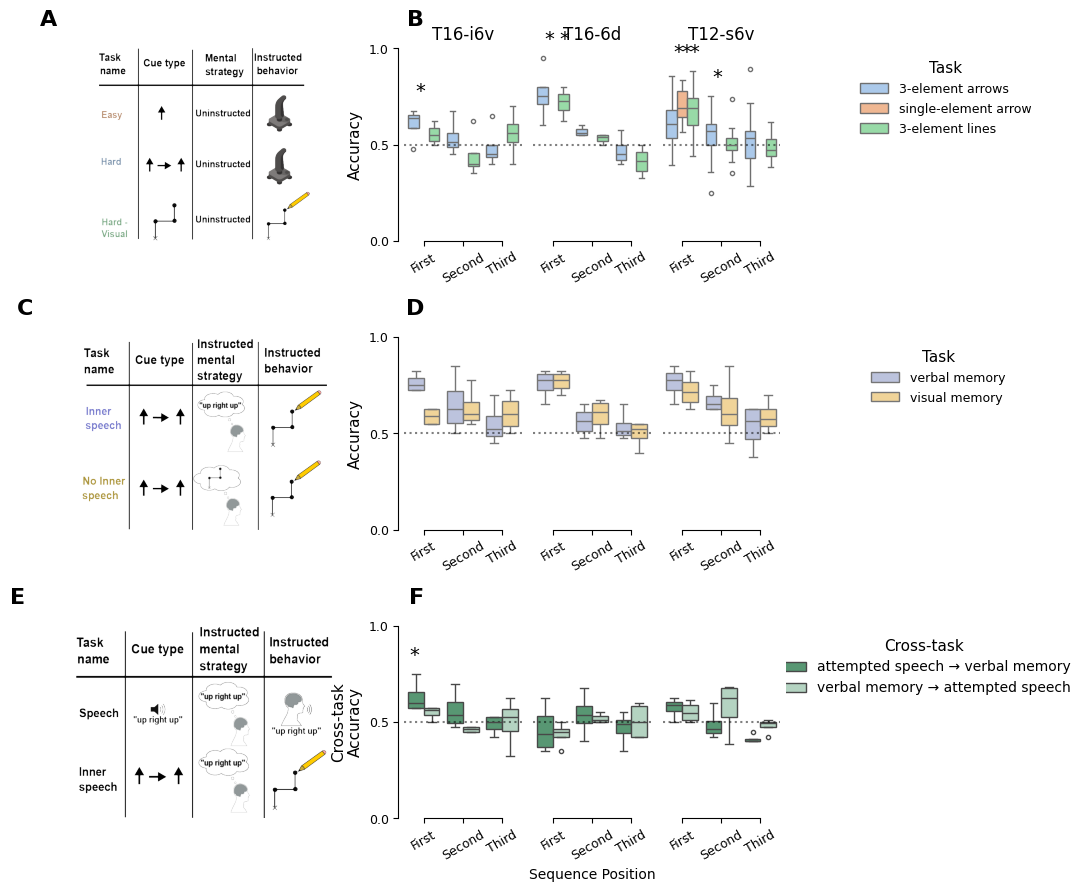

In [44]:

# Task design images
WIDTH_RATIOS = [3, 1, 1, 1]
WSPACE = 0
HSPACE = 0.5

LEGEND_LOC_EXP1 = [5, 1]
LEGEND_LOC_EXP2 = [4.8, 1]
LEGEND_LOC_EXP3 = [5.3, 1]

# EXP1_COLORS = sns.color_palette([]) TODO
EXP2_COLORS = sns.color_palette(['#B7C0E2', '#FFD98A'])
EXP3_COLORS = sns.color_palette(['#4DA271', '#afd8c0'])

regions = ['T16-i6v', 'T16-6d', 'T12-s6v']
fig = plt.figure(figsize=[10, 10], constrained_layout=False)
gs = fig.add_gridspec(3, 4, wspace=WSPACE, width_ratios=WIDTH_RATIOS, hspace=HSPACE)

# plot experiment 1
ax_tasks_exp1 = fig.add_subplot(gs[0, 0])
ax_tasks_exp1.imshow(plt.imread(FP_EXPERIMENT1_TASK))
ax_tasks_exp1.axis('off')
ax_tasks_exp1.text(-0.2, 1.2, 'A', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax_tasks_exp1.transAxes)

axs_exp1 = [fig.add_subplot(gs[0, i]) for i in range(1, 4)]
plot_box_compare_multiregion(experiment1DecodingResults_both_participants, regions=regions,
                             axs=axs_exp1, legend_loc=LEGEND_LOC_EXP1, 
                             sns_kws={'palette': 'pastel', 'hue_order': ['3-element arrows', 'single-element arrow', '3-element lines']},
                             experimentBootstrappedCI=experiment1BootstrappedCI_both_participants, x_pos_asterisk_offset=0.2)
for i, ax in enumerate(axs_exp1):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
axs_exp1[0].text(-1.8, 1.2, 'B', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax.transAxes)

# plot experiment 2
ax_tasks_exp2 = fig.add_subplot(gs[1, 0])
ax_tasks_exp2.imshow(plt.imread(FP_MENTAL_STRATEGY_SWAP_TASK))
ax_tasks_exp2.axis('off')
ax_tasks_exp2.text(-0.2, 1.2, 'C', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax_tasks_exp2.transAxes)

axs_exp2 = [fig.add_subplot(gs[1, i]) for i in range(1, 4)]
plot_box_compare_multiregion(experiment2DecodingResults_both_participants, regions=regions,
                             axs=axs_exp2, legend_loc=LEGEND_LOC_EXP2,
                             sns_kws={'palette': EXP2_COLORS, 'hue_order': ['verbal memory', 'visual memory']})
for i, ax in enumerate(axs_exp2):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title('')
axs_exp2[0].text(-1.8, 1.2, 'D', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax.transAxes)

# plot experiment 3
ax_tasks_exp3 = fig.add_subplot(gs[2, 0])
ax_tasks_exp3.imshow(plt.imread(FP_GENERALIZE_TASK))
ax_tasks_exp3.axis('off')
ax_tasks_exp3.text(-0.2, 1.2, 'E', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax_tasks_exp3.transAxes)

axs_exp3 = [fig.add_subplot(gs[2, i]) for i in range(1, 4)]
plot_box_compare_multiregion(crossTaskDecodingPerformance_both_participants, regions=regions,
                             axs=axs_exp3, legend_loc=LEGEND_LOC_EXP3, sns_kws={'palette': EXP3_COLORS,  
                                                                                },
                             experimentBootstrappedCI=experiment3BootstrappedCI_both_participants)
for i, ax in enumerate(axs_exp3):
    ax.set_title('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
axs_exp3[0].text(-1.8, 1.2, 'F', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax.transAxes)

axs_exp3[0].legend(bbox_to_anchor=LEGEND_LOC_EXP3 ,frameon=False).set_title('Cross-task', prop={'size': 11})
axs_exp3[0].set_ylabel('Cross-task\nAccuracy')
axs_exp3[1].set_xlabel('Sequence Position')

**Figure S3: Inner speech during task execution is also decodable in i6v in T16, whereas areas 6d in T16 and s6v in T12 exhibit hand-motor tuning**

**A)** T16 also completed the 3-element arrows and lines tasks without explicit instruction for mental strategy.
Due to T16's upper-extremity paralysis, attempted drawing was instructed as the desired behavior for
sequence recall (as opposed to actual drawing in participant T12). Task design for T12 is described in
Figure 4A. **B)** Decodability of sequence position was assessed as in Figure 4. For T16, a window of neural
activity from the first 1.5 seconds after the go cue was used to fit decoders. For T12 the same 2-second
delay period window was used as reported in Figure 4. For area i6v in T16, only the 3-element arrow task
elicited significant neural representation of the first sequence position. Our prior work75 has shown that area
6d in T16 and area s6v in T12 both encode hand-motor activity. In line with this, decoding performance was
similar across all tasks, particularly for the first sequence position for T12-s6v which is distinct from T12-i6v
results reported in Figure 4. Therefore, decoding results from these regions serve as a demonstration of
the validity of the motor and sequencing control tasks (single-element arrow, and 3-element lines). **C)** T16
performed two versions of the three-element arrows task, but with explicit instruction to either use or
suppress inner speech for short-term memory of the arrow sequence. **D)** Same as B but for tasks that only
differed in instructed mental strategy. Instruction to use verbal mental strategy significantly increased
decoding accuracy of the first position in area i6v in T16 (mean decoding accuracy 0.61, 95% CI 0.53-0.68)
but not in areas 6d in T16 nor area s6v in T12. **E)** T16 was visually cued by text to speak a direction to test
whether verbal short term memory in i6v had a shared representation with attempted speech. **F)** Same as
B except decoders are trained on attempted speech (verbal memory) and tested on verbal memory
(attempted speech). For T16 i6v, only attempted speech → verbal memory decoders could generalize
above chance for the first position. Decoders did not generalize well for area 6d in T16.